# Data Preprocessing and Exploratory Data Analysis (EDA)

This notebook explores the COCO dataset subset, visualizes augmentations, and checks label distributions.

In [1]:
from pathlib import Path
import sys
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

# Add the project root (parent of src) to sys.path
if "__file__" in globals():
    project_root = Path(__file__).resolve().parent.parent
else:
    project_root = Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
src_parent = project_root.parent
if str(src_parent) not in sys.path:
    sys.path.insert(0, str(src_parent))
from src.data.cocodataset import CocoDataset  # Updated import
from src import config  # Updated import
from src.utils.seed import set_seed

In [2]:
# Paths to the exported COCO dataset
base_export_path = Path(config.DATASET_ROOT)
images_dir = str(base_export_path / "train" / "data")
ann_file = str(base_export_path / "train" / "labels.json")

set_seed(42)

# Load datasets: without augment (val_transforms) and with augment (train_transforms)
dataset_raw = CocoDataset(images_dir, ann_file, transform=config.val_transforms)
dataset_aug = CocoDataset(images_dir, ann_file, transform=config.train_transforms)


# Function to denormalize and convert tensor to numpy image for plotting
def tensor_to_image(tensor_img: torch.Tensor):
    img = tensor_img.clone().detach()
    # Use mean and std from the config module
    for t, m, s in zip(img, config.MEAN, config.STD):
        t.mul_(s).add_(m)  # unnormalize
    np_img = img.numpy().transpose((1, 2, 0))
    return np.clip(np_img, 0, 1)

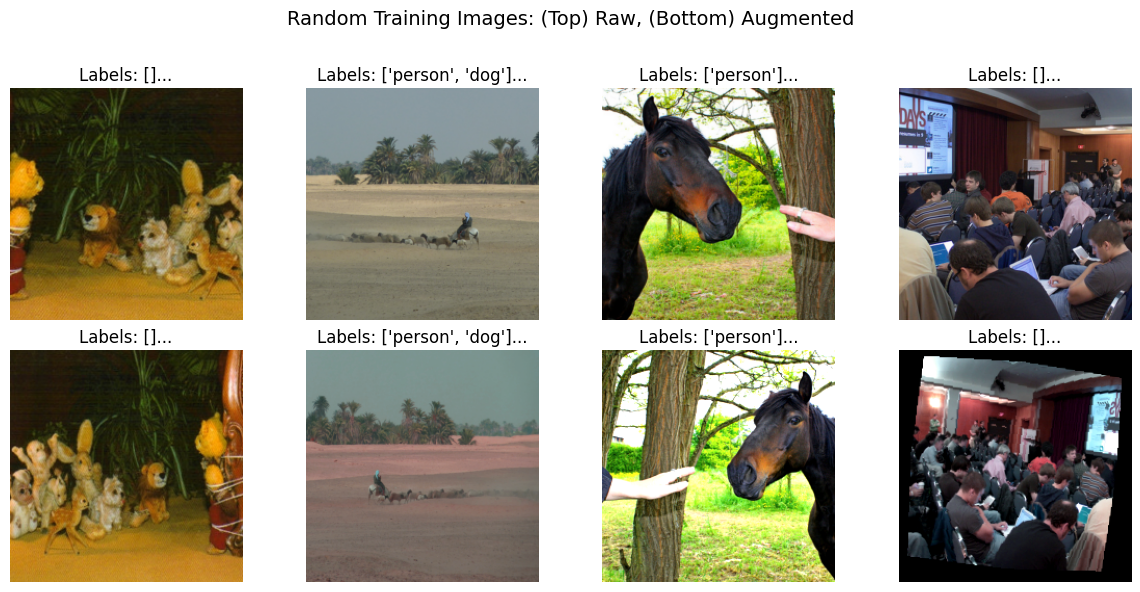

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Random Training Images: (Top) Raw, (Bottom) Augmented", fontsize=14)

for i in range(4):
    idx = random.randrange(len(dataset_aug))
    sample_raw = dataset_raw[idx]
    sample_aug = dataset_aug[idx]
    if sample_raw is None or sample_aug is None:
        print(f"Skipping corrupted sample at index {idx}")
        continue
    img_raw, label_raw = sample_raw
    img_aug, label_aug = sample_aug

    # Convert tensors to displayable images
    np_raw = tensor_to_image(img_raw)
    np_aug = tensor_to_image(img_aug)

    # Show raw image
    axes[0, i].imshow(np_raw)
    axes[0, i].axis("off")
    # Get class names for labels
    raw_class_indices = label_raw.nonzero().flatten().tolist()
    raw_class_names = [dataset_raw.category_names[j] for j in raw_class_indices]
    axes[0, i].set_title(f"Labels: {raw_class_names[:2]}...")  # Show first 2

    # Show augmented image
    axes[1, i].imshow(np_aug)
    axes[1, i].axis("off")
    aug_class_indices = label_aug.nonzero().flatten().tolist()
    aug_class_names = [dataset_aug.category_names[j] for j in aug_class_indices]
    axes[1, i].set_title(f"Labels: {aug_class_names[:2]}...")  # Show first 2 for


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

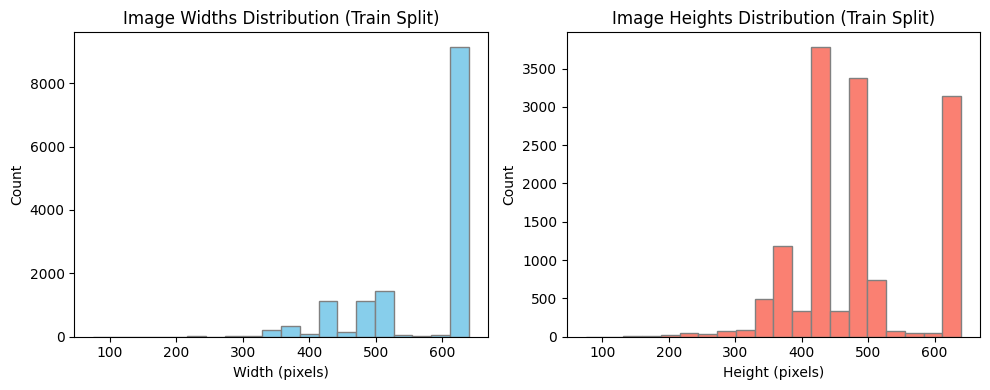

In [4]:
with open(ann_file, "r") as f:  # Using the train split's labels.json
    coco_data = json.load(f)
if "images" in coco_data and coco_data["images"]:
    widths = [img["width"] for img in coco_data["images"]]
    heights = [img["height"] for img in coco_data["images"]]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color="skyblue", edgecolor="gray")
    plt.title("Image Widths Distribution (Train Split)")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color="salmon", edgecolor="gray")
    plt.title("Image Heights Distribution (Train Split)")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

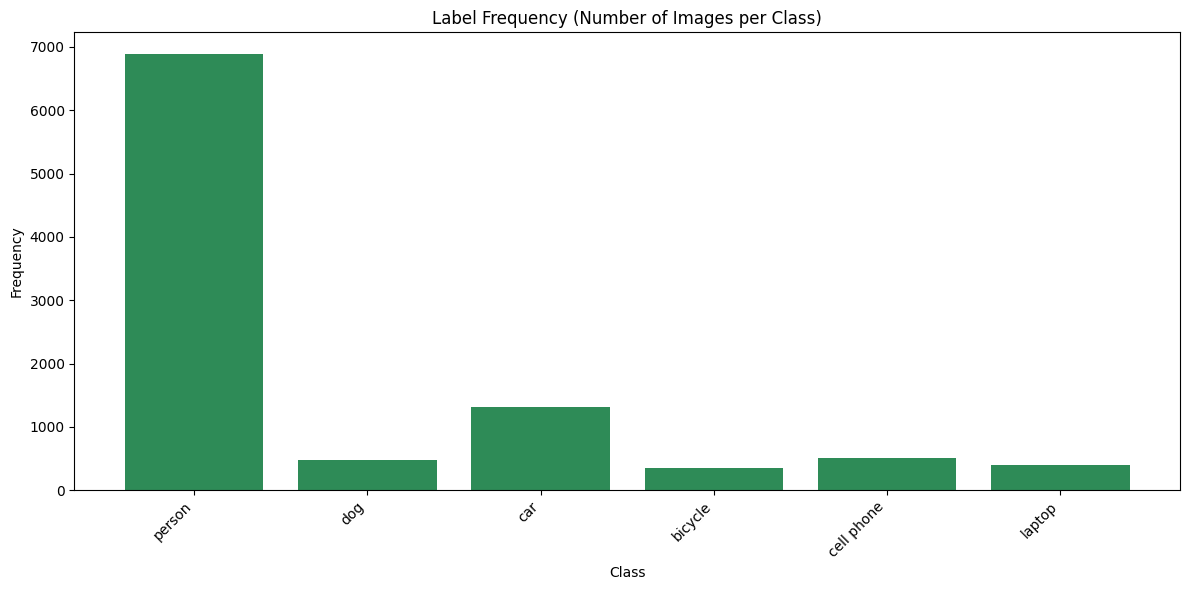

Example multi-hot label vectors (non-zero class indices):
Image 1 (Filename: 000000220529.jpg): Classes = ['person']
Image 2 (Filename: 000000101820.jpg): Classes = ['person']
Image 3 (Filename: 000000211190.jpg): Classes = ['person']


In [5]:
# Compute and plot label frequency across dataset
all_labels = torch.stack(dataset_raw.labels)  # Stack all label vectors into one tensor
label_counts = all_labels.sum(dim=0).numpy()
category_names = dataset_raw.category_names

plt.figure(figsize=(12, 6))  # Increased figure size for better readability
plt.bar(np.arange(len(label_counts)), label_counts, color="seagreen")
plt.title("Label Frequency (Number of Images per Class)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(np.arange(len(category_names)), category_names, rotation=45, ha="right")  # Use category names for x-ticks
plt.tight_layout()
plt.show()

# Print a few example label vectors to verify encoding
print("Example multi-hot label vectors (non-zero class indices):")
for i in range(min(3, len(dataset_raw))):  # Ensure we don't go out of bounds
    label_vec = dataset_raw.labels[i]
    classes = [dataset_raw.category_names[j] for j in (label_vec.nonzero().flatten().tolist())]
    print(f"Image {dataset_raw.image_ids[i]} (Filename: {dataset_raw.id_to_filename[dataset_raw.image_ids[i]]}): Classes = {classes}")

In [6]:
import os
from IPython.display import HTML
from IPython import get_ipython

# Get current notebook name
try:
    # Try to get the notebook name using IPython's special variable
    notebook_path = get_ipython().kernel.shell.user_ns["__vsc_ipynb_file__"] if "__vsc_ipynb_file__" in get_ipython().kernel.shell.user_ns else None
    if not notebook_path:
        notebook_path = get_ipython().kernel.shell.user_ns.get("__notebook_source__", "")
    notebook_name = os.path.basename(notebook_path) if notebook_path else ""
except Exception:
    notebook_name = ""

# Check if the notebook name was successfully determined
if notebook_name == "":
    # Fallback method if automatic detection fails
    notebook_name = input("Enter notebook filename (with .ipynb extension): ")

# Use nbconvert to export the notebook without input cells tagged with "remove"
# Ensure the assets directory exists
assets_dir = "../assets"
os.makedirs(assets_dir, exist_ok=True)
output_html = os.path.join(assets_dir, os.path.splitext(os.path.basename(notebook_name))[0] + "_export.html")
!jupyter nbconvert --to html --TagRemovePreprocessor.remove_cell_tags='{"remove"}' "{notebook_name}" --output "{output_html}"

# Display a success message
display(
    HTML(f"<div style=padding:10px;'>" f"<h3>Export complete!</h3>" f"<p>Notebook <b>{notebook_name}</b> has been exported to HTML.</p>" f"</div>")
)

[NbConvertApp] Converting notebook 02_preprocessing_eda.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 1421426 bytes to ../assets/02_preprocessing_eda_export.html
